## Augmentation options

### In time domain
- Pitch Shifting: PyRubberband
- Loudness (static and dynamic)
- Additive Gaussian Noise

### In frequency domain (changes timbre -> not desired)
- Time Warping
- Frequency and Time Masking
- Frequency Filtering

In [42]:
import augmentation

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def multiplay(clips, sf, title=None):
    outs = [widgets.Output() for c in clips]
    for ix, item in enumerate(clips):
        with outs[ix]:
            print(title[ix] if title is not None else "")
            display(Audio(item, rate=sf, normalize=True))
    return widgets.HBox(outs)

In [5]:
def tapering_window(N, overlap):
    R = int(N * overlap / 2)
    r = np.arange(0, R) / float(R)
    win = np.r_[r, np.ones(N - 2*R), r[::-1]]
    stride = N - R - 1 if R > 0 else N
    return win, stride

def pitchshift_gs_rt(x, alpha, grain_size, overlap=0.4):
    win, stride = tapering_window(grain_size, overlap)
    # resampling needs these many input samples to produce an output grain of the chosen size
    chunk_size = int(np.floor(grain_size + 1) * alpha)
    y = np.zeros(len(x))
    # input chunks and output grains are always aligned in pitch shifting (in_hop = out_hop = stride)
    for n in range(0, len(x) - max(chunk_size, grain_size), stride):
        y[n:n+grain_size] += resample(x[n:n+chunk_size], 1 / alpha) * win
    return y
semitone = 2 ** (1.0 / 12)
def ms2n(ms, sf):
    return int(float(sf) * float(ms) / 1000.0)
def resample(x, alpha):
    # length of the output signal after resampling
    n_out = int(np.floor(len(x) * alpha))
    y = np.zeros(n_out)
    for iy in range(0, n_out - 1):
        t = iy / alpha 
        ix = int(t)
        y[iy] = (1 - (t - ix)) * x[ix] + (t - ix) * x[ix + 1] 
    return y

C:\Users\User\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


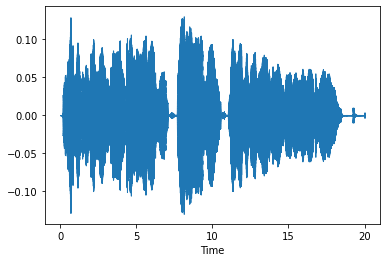

In [41]:
# import pyrubberband, librosa
from scipy import interpolate
import ipywidgets as widgets

link = "AlleMeineEndchen.m4a"
Audio(filename=link)

DUR = 20

x, sr = librosa.load(link,offset=2,duration=DUR)
SF = sr
plt.figure()
librosa.display.waveshow(x, sr=sr)
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))

In [35]:
# All
PST = augmentation.PitchShiftAugmentationTransformer(max_shift=4)
LAT = augmentation.LoudnessAugmentationTransformer(f_max=2)
AWGN = augmentation.AdditiveGaussianNoiseAugmentationTransformer(sigma_max=0.005)

DLAT = augmentation.DiverseLoudnessAugmentationTransformer(f_max=3, N=10000)

# Not really appropriate if timbre is to be learned
# TFWARP = augmentation.TimeFrequencyDomainTimeWarpAugmentationTransformer(max_warp_distance=0.05)
# TMASK = augmentation.TimeMaskingAugmentationTransformer(max_t=0.5)
# FMASK = augmentation.FrequencyMaskingAugmentationTransformer(max_f=0.2)

pipeline = [PST,LAT,DLAT,AWGN]#,TMASK]#,FMASK] #TFWARP

x_mod = []
for p in pipeline:
    x_mod.append(p(x))

multiplay([x,x_mod[0],x_mod[1],x_mod[2],x_mod[3]],sr, title=['ORIGINAL','PST', 'LAT','DLAT', 'AWGN'])

441000


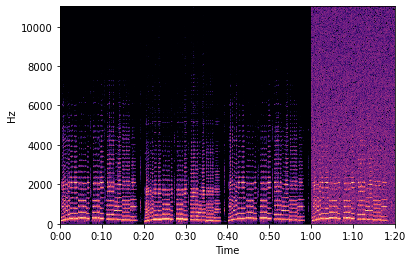

In [21]:
# Combine several: Do that in Chunks and then randomly

x_augmented = np.concatenate((x,x_mod[0],x_mod[1],x_mod[2]),axis=0)

X_aug = librosa.stft(PST(x_augmented))
X_aug_dB = librosa.amplitude_to_db(abs(X_aug))

librosa.display.specshow(X_aug_dB, sr=sr, x_axis='time', y_axis='hz')
plt.show()

multiplay([x_augmented],sr, title=['PST', 'LAT', 'AWGN'])

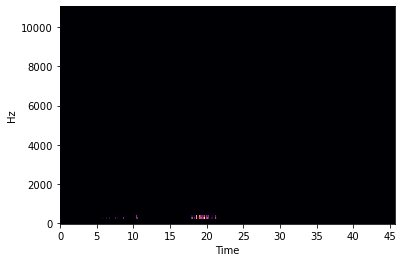

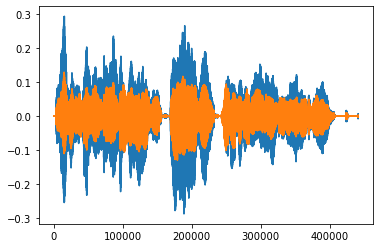

In [34]:
# Dynamically adapt loudness during piece (time constant of change: N/sample_rate)
DLAT = augmentation.DiverseLoudnessAugmentationTransformer(f_max=3, N=10000)
x_mod = DLAT(x)

plt.plot(x_mod)
plt.plot(x)

multiplay([x,x_mod],sr, title=['ORIGINAL','DLAT'])

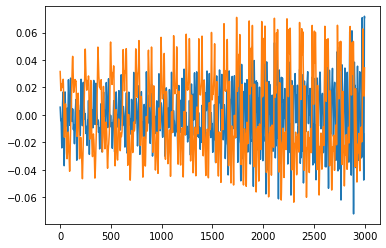

In [43]:
# Time Stretching Augmentation
TST = augmentation.TimeStretchingTransformer(strectch_factor=0.8, sample_rate=SF)
x_mod = TST(x)

plt.plot(x_mod[9000:12000])
plt.plot(x[9000:12000])

multiplay([x,x_mod],sr, title=['ORIGINAL','TST'])

(441000,) (441000,)


5.0

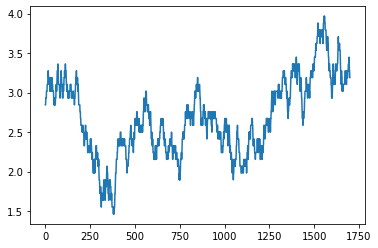

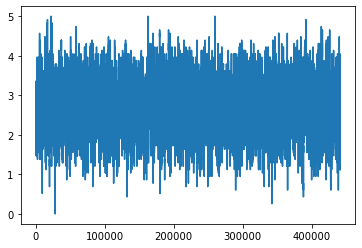

In [13]:
# Developing the Dynamic Loundness Transformer

weigthing = np.random.randint(0,2,len(x))
N = 200
weigthing = 2*np.convolve(weigthing, np.ones(N)/N, mode='valid') - 1 
weigthing = np.concatenate((weigthing[0:(len(x)-len(weigthing))//2],weigthing,weigthing[-(len(x)-len(weigthing))//2:]))
# weigthing = 2/2 / np.max(np.abs(weigthing)) * (weigthing + 1)
weigthing = weigthing - np.mean(weigthing)
weigthing -= np.min(weigthing)
weigthing *= 5 / np.max(weigthing)


print(weigthing.shape, x.shape)


plt.figure()
plt.plot(weigthing[300:2000])
plt.figure()
plt.plot(weigthing[:])

weigthing.max()

In [ ]:
# Warping -> only use in FreqDomain
TFWARP = augmentation.TimeFrequencyDomainTimeWarpTransformer(warp_distance=2)
X_ = np.abs(librosa.stft(x))**2
ts,freqs,X_ = signal.spectrogram(x,fs=SF)
X_2 = TFWARP(X_)
librosa.display.specshow(librosa.amplitude_to_db(X_2), sr=sr, x_axis='time', y_axis='hz')
plt.show()